# Predict Survival on Titanic Datasets Using Classification Methods(Part 1)

## Introduction
One of the most famous shipwrecks in the history, the sinking of Titanic, is still often mentioned today. This great ship sank in the North Atlantic Ocean in the early morning of 15 April 1912, after it collided with an iceberg. This tragedy shocked the whole international community. There were more than 1500 people out of 2224 passengers and crew died in this tragedy. The RMS Titanic was the largest ship afloat at the time it entered service and was the second of three Olympic-class ocean liners operated by the White Star Line. The Titanic was built by the Harland and Wolff shipyard in Belfast. Thomas Andrews, her architect, died in the disaster.

In this notebook, we aim to provide multiple classification machine learning methods on Titanic train data, to predict whether a passenger would be survived on Titanic or not on the test dataset. The Machine learning tools include: Naive Bayes, Support Vector Machine(SVM), K-Nearest Neighbour(KNN), Decision Tree Classifier, Random Forest Classifier, AdaBoost Classifier, Gradient Boosting Classifier, Logistic Regression with Regularization(Ridge & LASSO).


## Part 1. Exploratory Data Analysis(EDA)

In this section, we will do data preprocessing, including data wrangling, data visualization, feature engineering and missing value processing, to explore and summarize the main characteristics of the Titanic dataset.
<img src = "EDA.png" width = 350>


### 1.0 Load Packages
We mainly use packages as follows:

In [80]:
import numpy as np 
import pandas as pd
from pandas import get_dummies
import scipy.stats as stats
import re

import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns

from sklearn.cross_validation import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC, LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

%matplotlib inline

### 1.1 Import the Dataset and Do Data Wrangling
To begin with, we first import the data, then apply function shape(), info() and isnull() to get a quick and dirty overview of the features. This step is a preparation for the feature engineering step, which can provide us some clues on the big picture of the project.

In [81]:
# Read the tables
Data = pd.read_csv("TitanicData/train.csv") 
Data_test = pd.read_csv("TitanicData/test.csv") 
Data_test_survive = pd.read_csv("TitanicData/gender_submission.csv") 
print('Type of data: ',type(Data))
print('------------------------------------------')
print('Dimension of train table: ',Data.shape)#891 x 12
print('Dimension of test table: ',Data_test.shape)#418 x 11
print('Dimension of gender_submission table: ',Data_test_survive.shape)#418 x 2
print('------------------------------------------')
print('train table summary: ',Data.info())
print('------------------------------------------')
print('test table summary: ',Data_test.info())
print('------------------------------------------')
print('gender_submission table summary: ',Data_test_survive.info())

Type of data:  <class 'pandas.core.frame.DataFrame'>
------------------------------------------
Dimension of train table:  (891, 12)
Dimension of test table:  (418, 11)
Dimension of gender_submission table:  (418, 2)
------------------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 83.6+ KB
train table summary:  None
------------------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns 

In [82]:
Data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [83]:
# Missing value summary
print('train Set NA: ')
print(Data.isnull().sum())
print('------------------------------------------')
print('test Set NA: ')
print(Data_test.isnull().sum())
print('------------------------------------------')
print('gender_submission NA: ')
print(Data_test_survive.isnull().sum())

train Set NA: 
PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64
------------------------------------------
test Set NA: 
PassengerId      0
Pclass           0
Name             0
Sex              0
Age             86
SibSp            0
Parch            0
Ticket           0
Fare             1
Cabin          327
Embarked         0
dtype: int64
------------------------------------------
gender_submission NA: 
PassengerId    0
Survived       0
dtype: int64


At a first glance, we find:

(1)There are some missing values in column 'Age' and 'Cabin' in both train and test table. Besides, there are 2 missing values in 'Embarked' column in train table and 1 missing value in 'Fare' in test table.

(2)There are 12 columns in the train table, 11 columns in the test table and 2 columns in the 'gender_submission' table. 'PassengerId' column appears in all three tables. Column 'Survived' is the target variable and other columns are the predictor variables.

Usually, we can use machine learning algorithms on train data, do the prediction and data evaluation on the test data. However, considering that there might be some potential information from 'Name' column, we need to split column 'Name' in both train and test datasets. So we plan to merge train and test set together and do spliting after data preprocessing.

In [84]:
# Data wrangling
titanic_test = pd.merge(Data_test, Data_test_survive, how ='outer', on = 'PassengerId')
print('Test Set Dimension: ',titanic_test.shape)

Test_Id = titanic_test['PassengerId']

Titanic0 = Data.append(titanic_test)
print('Whole Set Dimension: ',Titanic0.shape)
print('------------------------------------------')
print(Titanic0.isnull().sum())

#cols = Titanic0.columns.tolist()
#cols.insert(0, cols.pop(cols.index('PassengerId')))
#Titanic = Titanic0.reindex(columns= cols)
Titanic0 = Titanic0.set_index('PassengerId')
Titanic0.head()

Test Set Dimension:  (418, 12)
Whole Set Dimension:  (1309, 12)
------------------------------------------
Age             263
Cabin          1014
Embarked          2
Fare              1
Name              0
Parch             0
PassengerId       0
Pclass            0
Sex               0
SibSp             0
Survived          0
Ticket            0
dtype: int64


,Age,Cabin,Embarked,Fare,Name,Parch,Pclass,Sex,SibSp,Survived,Ticket
PassengerId,,,,,,,,,,,
1,22.0,NaN,S,7.2500,"Braund, Mr. Owen Harris",0,3,male,1,0,A/5 21171
2,38.0,C85,C,71.2833,"Cumings, Mrs. John Bradley (Florence Briggs Th...",0,1,female,1,1,PC 17599
3,26.0,NaN,S,7.9250,"Heikkinen, Miss. Laina",0,3,female,0,1,STON/O2. 3101282
4,35.0,C123,S,53.1000,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",0,1,female,1,1,113803
5,35.0,NaN,S,8.0500,"Allen, Mr. William Henry",0,3,male,0,0,373450


### 1.2 Feature Engineering and Data visualzation
The whole dataset has 1309 rows, which equals to the sum of the rows from train set(891) and test set(418). It means no coincident passengerId in two sets. 

After simple data wrangling, let's take a look at the titanic table again. There are 12 columns in this table:
##### Target variable:
* Survived: Survived (1) or died (0)

##### Predictor variables:
* Cabin: Cabin number
* Embarked: Port of Embarkation(C = Cherbourg, Q = Queenstown, S = Southampton)
* Fare: Passenger fare
* Parch: # of parents / children aboard the Titanic
* Pclass: Ticket class(1 = 1st, 2 = 2nd, 3 = 3rd)
* SibSp: # of siblings / spouses aboard the Titanic
* Ticket: Ticket number

In this section, we plan to do the following steps:

(1) Split column 'Name' and extract a new column called 'Titles'. From the title column, we may get more information on the gender and age perspective

(2) Variable 'Ticket' and 'Cabin' are obviously unuseful, we remove them from the table

(3) Missing value processing

(4) Explore relationships between target variable and predictor variables using data visualization, get more useful information on how to deal with each type of features. 'Parch' and 'SibSp' can combine together, we will create a new column called 'NumFamily' to show the number of family members aboard the Titanic


### 1.2.1 Extract Title column
Variable 'Name' has titles such as 'Mr.','Mrs.','Miss.','Master.'. Extract titles from passenger names may be helpful.

Title names:  ['Mr' 'Mrs' 'Miss' 'Master' 'Don' 'Rev' 'Dr' 'Mme' 'Ms' 'Major' 'Lady'
 'Sir' 'Mlle' 'Col' 'Capt' 'Countess' 'Jonkheer' 'Dona']
------------------------------------------------------


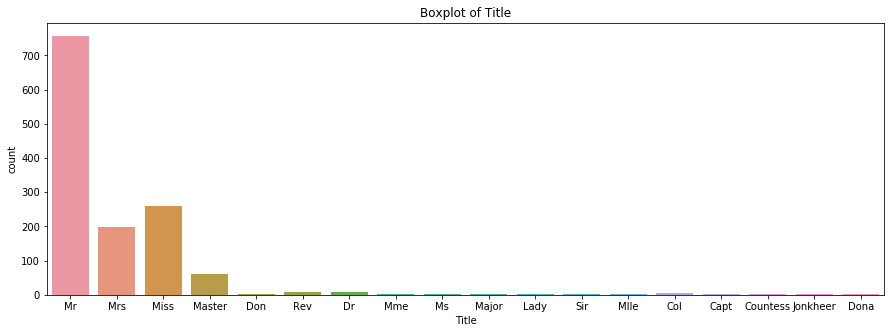

Title,Capt,Col,Countess,Don,Dona,Dr,Jonkheer,Lady,Major,Master,Miss,Mlle,Mme,Mr,Mrs,Ms,Rev,Sir
Sex,,,,,,,,,,,,,,,,,,
female,0,0,1,0,1,1,0,1,0,0,260,2,1,0,197,2,0,0
male,1,4,0,1,0,7,1,0,2,61,0,0,0,757,0,0,8,1


In [85]:
# Define function to extract titles from passenger names
def get_title(name):
    title_search = re.search(' ([A-Za-z]+)\.', name)
    # If the title exists, extract and return it.
    if title_search:
        return title_search.group(1)
    return ""
# Create a new feature Title, containing the titles of passenger names
Titanic0['Title'] = Titanic0['Name'].apply(get_title)
print('Title names: ',Titanic0['Title'].unique())
print('------------------------------------------------------')

f,ax=plt.subplots(figsize=(15,5))
sns.countplot('Title',data=Titanic0)
ax.set_title('Boxplot of Title')
plt.show()

pd.crosstab(Titanic0['Sex'],Titanic0['Title']).style.background_gradient(cmap='summer_r')

From the boxplot above, we find most passengers used 4 titles 'Mr' 'Mrs' 'Miss' 'Master'. Group all non-common titles into 'Others' group seems a good idea. Meanwhile, there are some synonyms, such as 'Ms' 'Miss' and 'Mme' are the same as 'Mrs'. we need to convert them into the same titles.

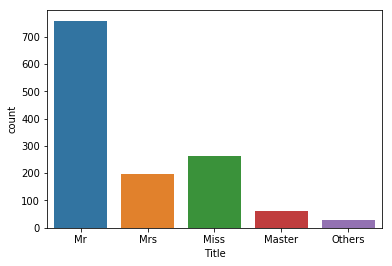

In [86]:
Titanic0['Title'] = Titanic0['Title'].replace(['Don','Rev','Dr','Major','Lady','Col','Capt','Countess','Jonkheer','Dona'], 'Others')
Titanic0['Title'] = Titanic0['Title'].replace('Mlle', 'Miss')
Titanic0['Title'] = Titanic0['Title'].replace('Ms', 'Miss')
Titanic0['Title'] = Titanic0['Title'].replace('Mme', 'Mrs')
Titanic0['Title'] = Titanic0['Title'].replace('Sir', 'Mr')
sns.countplot('Title',data=Titanic0)

### 1.2.2 Remove unuseful variables

In [87]:
#print(Titanic0[['Cabin','Pclass','Fare']][Titanic0['Cabin'].notnull()].loc[Titanic0['Pclass'] == 1])
#print('-----------------------------------------------')
#print(Titanic0[['Cabin','Pclass','Fare']][Titanic0['Cabin'].notnull()].loc[Titanic0['Pclass'] == 2])
#print('-----------------------------------------------')
#print(Titanic0[['Cabin','Pclass','Fare']][Titanic0['Cabin'].notnull()].loc[Titanic0['Pclass'] == 3])
Titanic = Titanic0.drop(['Cabin','Ticket','Name'],axis = 1)
Titanic.head()

,Age,Embarked,Fare,Parch,Pclass,Sex,SibSp,Survived,Title
PassengerId,,,,,,,,,
1,22.0,S,7.2500,0,3,male,1,0,Mr
2,38.0,C,71.2833,0,1,female,1,1,Mrs
3,26.0,S,7.9250,0,3,female,0,1,Miss
4,35.0,S,53.1000,0,1,female,1,1,Mrs
5,35.0,S,8.0500,0,3,male,0,0,Mr


OK, right now, Let's split Titanic data into training set and test set. Do all exploration on both sets, and do training on train set, comparing the models using evaluation results from test set.

In [88]:
#Testset = Titanic.loc[Titanic.index.isin(Test_Id.tolist())]
#Trainset = Titanic.loc[~Titanic.index.isin(Test_Id.tolist())]
#Testset.shape#418 10
#Trainset.shape#891 10
#Testset.head()

### 1.2.3 Missing Value Processing
In previous section, we find that there are 177 missing values in column 'Age', 687 missing values in 'Cabin', 2 in 'Embarked' and 1 in 'Fare'. As we remove 'Cabin' from dataset, we just consider the NA problem on three features left. We have several methods to fix NA problem:

(1) Remove rows with NA: This method is not very effective, unless the tuple contains several attributes with missing values. By ignoring the tuple, we do not make use of the remaining attributes’ values in the tuple. 

(2) Fill in the missing value manually:
In general, this approach is time consuming and may not be feasible given a large data set with many missing values.

(3) Fill NA with some values, such as choosing mean, median, mode to fill in the blank: For normal (symmetric) data distributions, the mean can be used, while skewed data distribution should employ the median

(4) Use the attribute mean or median for all samples belonging to the same class

(5) Determine missing value using ML tools such as regression and Bayesian inference: predict missing values with machine learning. https://stackoverflow.com/questions/40996051/predict-na-missing-values-with-machine-learning

Which method should we use?

##### For 'Embarked' column
Because just 2 missing values in "Embarked" column, no matter what we fill the missing values, it will not occur big mistake. So we use the name of port which has the largest amount of passengers: Southampton(S) to fill in the blank

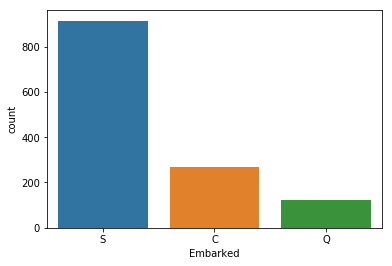

--------------------------------------
Number of NA now: 0


In [89]:
f,ax=plt.subplots(figsize=(6,4))
sns.countplot('Embarked',data=Titanic)
plt.show()
Titanic['Embarked'].fillna('S',inplace=True)
print('--------------------------------------')
print('Number of NA now:',Titanic["Embarked"].isnull().sum())

##### For 'Fare' column
Just 1 missing value in "Fare" column.  After checking the histogram, we find a right-skewness. To fill in blank, using median seems to be a good idea

--------------------------------------
Number of NA now: 0


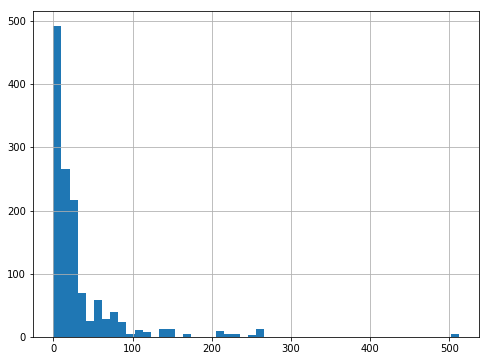

In [90]:
Titanic['Fare'].hist(bins = 50,figsize=(8,6))
Titanic["Fare"].fillna(Titanic["Fare"].median(), inplace=True)
print('--------------------------------------')
print('Number of NA now:',Titanic["Fare"].isnull().sum())

/Users/eluo/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
/Users/eluo/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
/Users/eluo/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


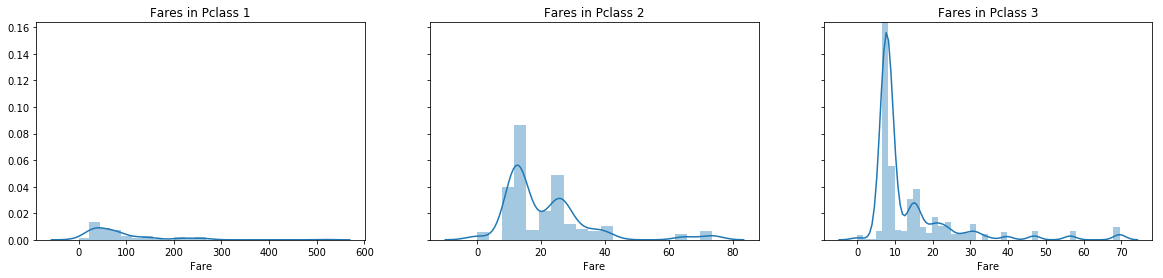

In [91]:
f,ax=plt.subplots(1,3,figsize=(20,4),sharey = True)
sns.distplot(Titanic[Titanic['Pclass']==1].Fare,ax=ax[0])
ax[0].set_title('Fares in Pclass 1')
sns.distplot(Titanic[Titanic['Pclass']==2].Fare,ax=ax[1])
ax[1].set_title('Fares in Pclass 2')
sns.distplot(Titanic[Titanic['Pclass']==3].Fare,ax=ax[2])
ax[2].set_title('Fares in Pclass 3')
plt.show()

From displots above, we find the different fare price range of 3 different levels of Pclass. As the number of passengers in Pclass3 is largest, the height of Pclass3 distplot is the highest, the height of Pclass1 is the lowest. 

##### For 'Age' column
There are 177 missing values in Age column, it is not a small number. We cannot simply remove these rows. Let's check histogram first. The histogram is a little right-skewed, we can use four different methods to fill the blank:

(1)First Method: Fill in blank with Median value

(2)Second Method: Fill in blank with Median value for all samples belonging to the same class

(3)Third Method: Fill in blank with prediction using ML tools such as random forest regressor.
In the third method, we plan to use the rows without NA as trainset and validation set, apply 10-Fold CV random forest regression on them. Then use the rows with NA to do prediction. This method will help us fill the blank. However, Data leakage is a big concern. We need to exclude 'Survived' column when we do modeling on training and validation set. 

(4)Fourth Method: Fill in blank with random sample between (mean - std) and (mean + std)

Note: More specific details of decision tree and random forest regression will be introduced in part 2 of this project. If you are interested in K-fold CV Random forest, please see the link: https://towardsdatascience.com/hyperparameter-tuning-the-random-forest-in-python-using-scikit-learn-28d2aa77dd74

In [92]:
# For 'Age' column

print('Number of NA from Original Titanic Data:',Titanic["Age"].isnull().sum())
# f,ax = plt.subplots(3,2,figsize=(20,15))
# Titanic['Age'].hist(bins = 60,ax = ax[0][0])
# ax[0][0].set_title('Histogram Age Original',fontsize=13)
# ax[0][0].set_ylabel('Count')
print('---------------------------------------------------------------')

############ Method 1 ###############
print("First Method: Fill in blank with Median value" )
Titanic1 = Titanic.copy()
Titanic1["Age"].fillna(Titanic1["Age"].median(), inplace=True)
print('Number of NA after Method1:',Titanic1["Age"].isnull().sum())
# Titanic1['Age'].hist(bins = 60,ax = ax[0][1])
# ax[0][1].set_title('Histogram Age Method1',fontsize=13)
# ax[0][1].set_ylabel('Count')
print('---------------------------------------------------------------')

############ Method 2 ###############
print("Second Method: Fill in blank with Median value for all samples belonging to the same class" )
print('lets check the average age by',Titanic.groupby('Title')['Age'].mean())
Titanic2 = Titanic.copy()
Titanic2.loc[(Titanic2.Age.isnull())&(Titanic2.Title=='Mr'),'Age']=32
Titanic2.loc[(Titanic2.Age.isnull())&(Titanic2.Title=='Mrs'),'Age']=37
Titanic2.loc[(Titanic2.Age.isnull())&(Titanic2.Title=='Master'),'Age']=5
Titanic2.loc[(Titanic2.Age.isnull())&(Titanic2.Title=='Miss'),'Age']=22
Titanic2.loc[(Titanic2.Age.isnull())&(Titanic2.Title=='Others'),'Age']=45
print('Number of NA after Method 2 :',Titanic2["Age"].isnull().sum())
# Titanic2['Age'].hist(bins = 60,ax = ax[1][0])
# ax[1][0].set_title('Histogram Age Method2',fontsize=13)
# ax[1][0].set_ylabel('Count')
print('---------------------------------------------------------------')

############ Method 3 ###############
print("Third Method: Fill in blank with prediction using ML tools such as random forest regressor" )
Titanic3 = Titanic.copy()
Titanic3.loc[Titanic3.Title=='Mr','Title'] = '0'
Titanic3.loc[Titanic3.Title=='Mrs','Title']= '1'
Titanic3.loc[Titanic3.Title=='Master','Title']= '2'
Titanic3.loc[Titanic3.Title=='Miss','Title']= '3'
Titanic3.loc[Titanic3.Title=='Others','Title']= '4'
Titanic3.loc[Titanic3.Sex=='male','Sex']= '0'
Titanic3.loc[Titanic3.Sex=='female','Sex']= '1'
Titanic3.loc[Titanic3.Embarked=='C','Embarked']= '0'
Titanic3.loc[Titanic3.Embarked=='Q','Embarked']= '1'
Titanic3.loc[Titanic3.Embarked=='S','Embarked']= '2'

Titanic3['Title'] = [int(x) for x in Titanic3['Title']]
Titanic3['Sex'] = [int(x) for x in Titanic3['Sex']]
Titanic3['Embarked'] = [int(x) for x in Titanic3['Embarked']]

Titanic3['Title'] = Titanic3['Title'].astype('category',ordered=False)
Titanic3['Sex'] = Titanic3['Sex'].astype('category',ordered=False)
Titanic3['Embarked'] = Titanic3['Embarked'].astype('category',ordered=False)
Titanic3['Pclass'] = Titanic3['Pclass'].astype('category',ordered=True)

Train_3 = Titanic3.loc[Titanic3['Age'].notnull()]
Test_3 = Titanic3.loc[Titanic3['Age'].isnull()]#263 9
NanRows = Train_3.index.tolist()#263

#Train_3_t, Train_3_v = train_test_split(Train_3, random_state=0,train_size = 0.8)
#Train_3_t_X = Train_3_t[['Embarked', 'Fare', 'Parch', 'Pclass', 'Sex', 'SibSp','Survived', 'Title']]
#Train_3_t_y = Train_3_t['Age']
#Train_3_v_X = Train_3_v[['Embarked', 'Fare', 'Parch', 'Pclass', 'Sex', 'SibSp','Survived', 'Title']]
#Train_3_v_y = Train_3_v['Age']
Train_3_X = Train_3[['Embarked', 'Fare', 'Parch', 'Pclass', 'Sex', 'SibSp', 'Title']]
Train_3_y = Train_3['Age']
Test_3_X = Test_3[['Embarked', 'Fare', 'Parch', 'Pclass', 'Sex', 'SibSp', 'Title']]
Test_3_y = Test_3['Age']

from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
from pprint import pprint
from sklearn.metrics import mean_squared_error

# First create the base model to tune
rf = RandomForestRegressor()
print('Parameters currently in use:\n')
print(pprint(rf.get_params()))
# Tuning Random Hyperparameter
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 2, stop = 302, num = 5)]
# Method of selecting samples for training each tree
bootstrap = [True, False]
random_grid = {'n_estimators': n_estimators,'bootstrap': bootstrap}
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, random_state=0, cv = 5, verbose=2, n_jobs = -1)

# fit the model
rf_random.fit(Train_3_X, Train_3_y)
print('Optimal parameters: ',rf_random.best_params_)

pred = rf_random.predict(Test_3_X)

Test_3['Pred'] = pred
Test_3 = Test_3.drop('Age',axis = 1)
Test_3 = Test_3.rename(columns = {'Pred':'Age'})

Titanic4 = Train_3.append(Test_3)
print('Number of NA after Method 3:',Titanic4["Age"].isnull().sum())
# Titanic4['Age'].hist(bins = 60,ax = ax[1][1])
# ax[1][1].set_title('Histogram Age Method3',fontsize=13)
# ax[1][1].set_ylabel('Count')
print('-------------------------------------------------------')

############## Method 4 #################
Titanic5 = Titanic.copy()
average_age   = Titanic5["Age"].mean()
std_age     = Titanic5["Age"].std()
count_nan_age = Titanic5["Age"].isnull().sum()
rand_1 = np.random.randint(average_age - std_age, average_age + std_age, size = count_nan_age)
Titanic5["Age"][np.isnan(Titanic5["Age"])] = rand_1
print('Number of NA after Method 4:',Titanic5["Age"].isnull().sum())
# Titanic5['Age'].hist(bins = 60,ax = ax[2][0])
# ax[2][0].set_title('Histogram Age Method3',fontsize=13)
# ax[2][0].set_ylabel('Count')

# plt.show()

Number of NA from Original Titanic Data: 263
---------------------------------------------------------------
First Method: Fill in blank with Median value
Number of NA after Method1: 0
---------------------------------------------------------------
Second Method: Fill in blank with Median value for all samples belonging to the same class
lets check the average age by Title
Master     5.482642
Miss      21.824366
Mr        32.280928
Mrs       36.918129
Others    45.037037
Name: Age, dtype: float64
Number of NA after Method 2 : 0
---------------------------------------------------------------
Third Method: Fill in blank with prediction using ML tools such as random forest regressor
Parameters currently in use:

{'bootstrap': True,
 'criterion': 'mse',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 10,
 'n_jo

[Parallel(n_jobs=-1)]: Done  41 tasks      | elapsed:   15.0s


[CV] ................ n_estimators=227, bootstrap=False, total=   1.8s
[CV] n_estimators=302, bootstrap=False ...............................
[CV] ................ n_estimators=227, bootstrap=False, total=   1.9s
[CV] n_estimators=302, bootstrap=False ...............................
[CV] ................ n_estimators=227, bootstrap=False, total=   1.8s
[CV] n_estimators=302, bootstrap=False ...............................
[CV] ................ n_estimators=302, bootstrap=False, total=   2.4s
[CV] n_estimators=302, bootstrap=False ...............................
[CV] ................ n_estimators=302, bootstrap=False, total=   2.5s
[CV] ................ n_estimators=302, bootstrap=False, total=   2.2s
[CV] ................ n_estimators=302, bootstrap=False, total=   2.0s
[CV] ................ n_estimators=302, bootstrap=False, total=   1.6s


[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:   19.5s finished


Optimal parameters:  {'n_estimators': 227, 'bootstrap': True}
Number of NA after Method 3: 0
-------------------------------------------------------
Number of NA after Method 4: 0


/Users/eluo/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:96: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/eluo/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:113: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


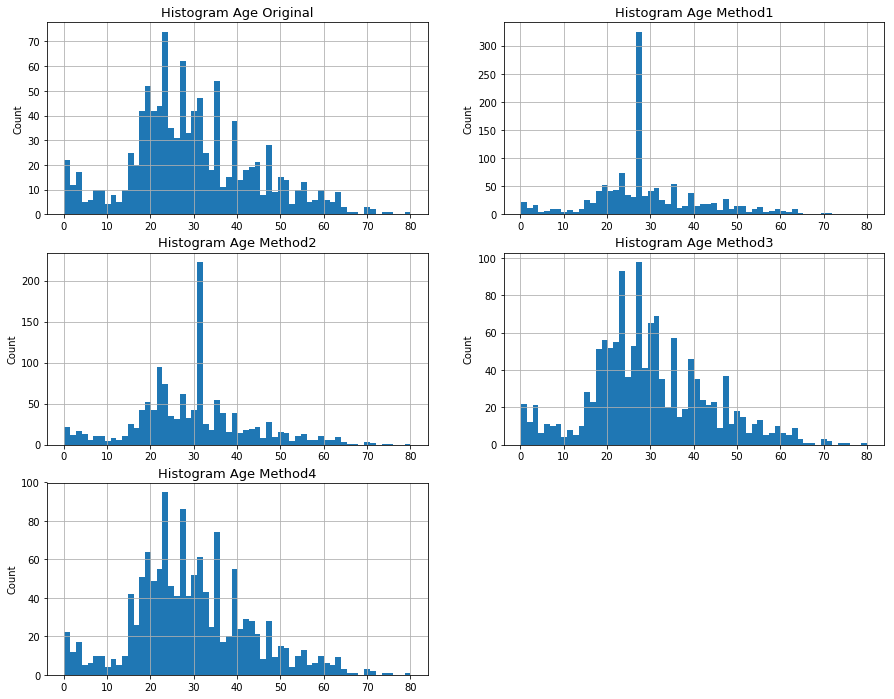

In [93]:
f,ax = plt.subplots(3,2,figsize=(15,12))

Titanic['Age'].hist(bins = 60,ax = ax[0][0])
ax[0][0].set_title('Histogram Age Original',fontsize=13)
ax[0][0].set_ylabel('Count')

Titanic1['Age'].hist(bins = 60,ax = ax[0][1])
ax[0][1].set_title('Histogram Age Method1',fontsize=13)
ax[0][1].set_ylabel('Count')

Titanic2['Age'].hist(bins = 60,ax = ax[1][0])
ax[1][0].set_title('Histogram Age Method2',fontsize=13)
ax[1][0].set_ylabel('Count')

Titanic4['Age'].hist(bins = 60,ax = ax[1][1])
ax[1][1].set_title('Histogram Age Method3',fontsize=13)
ax[1][1].set_ylabel('Count')

Titanic5['Age'].hist(bins = 60,ax = ax[2][0])
ax[2][0].set_title('Histogram Age Method4',fontsize=13)
ax[2][0].set_ylabel('Count')

f.delaxes(ax[2][1])
plt.show()

Intutively, to fill in the missing value of one record, the best way is to find the similar records. Here we implement the random forest regression model to predict missing values using the 'similar' records, the values of prediction makes more sense than median value. Comparing the original histogram and the results of 4 filling methods, we prefer the last two methods to deal with NAs. I will use Titanic5(Method4 dataset) to do data visualization and machine leaning then.

### 1.2.4 Explore Data Using Data Visualization

Titanic tragedy is one of the deadiest sinking disaster in our history. Looking at the pie plot of 'Survived' column, we can see: Just 37.7% of passengers survived.

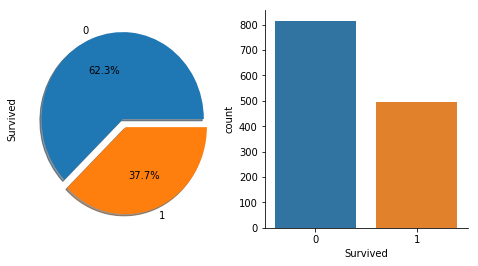

In [94]:
f,ax=plt.subplots(1,2,figsize=(8,4))
Titanic4['Survived'].value_counts().plot.pie(explode=[0,0.1],ax = ax[0],autopct='%1.1f%%',shadow=True)
sns.countplot(x = 'Survived',data = Titanic5,ax = ax[1])

ax[1].spines['top'].set_visible(False)
ax[1].spines['right'].set_visible(False) 

plt.show()

It is evident that not many passengers survived the accident. We need to dig down more to get better insights from the data and see which categories of the passengers did survive and who didn't. We will try to check the survival rate by using the different features of the dataset. Some of the features being Sex, Port Of Embarcation, Age,etc. We plan to deal with them based on different feature types: continuous, ordinary or categorical.

###### Categorical Features: 
These features have several categories, we cannot sort the categories by deciding which category is larger/better than others. 'Sex','Title','Embarked' are categorical features obviously. 

###### Continuous Features: 
A feature is said to be continous if it can take values between any two points or between the minimum or maximum values in the features column, such as 'Age' 

###### Ordinary Features: 
There are several categories which can be sorted, for example 'Pclass'.


### Let's create some plots to show which kind of passengers will have more opportunity to survive in this horrible disaster. 

##### * Histrogram for Continuous variables
'Age' and ' Fare' are continuous features. We will get an idea of their distributions using histogram.

/Users/eluo/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
/Users/eluo/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


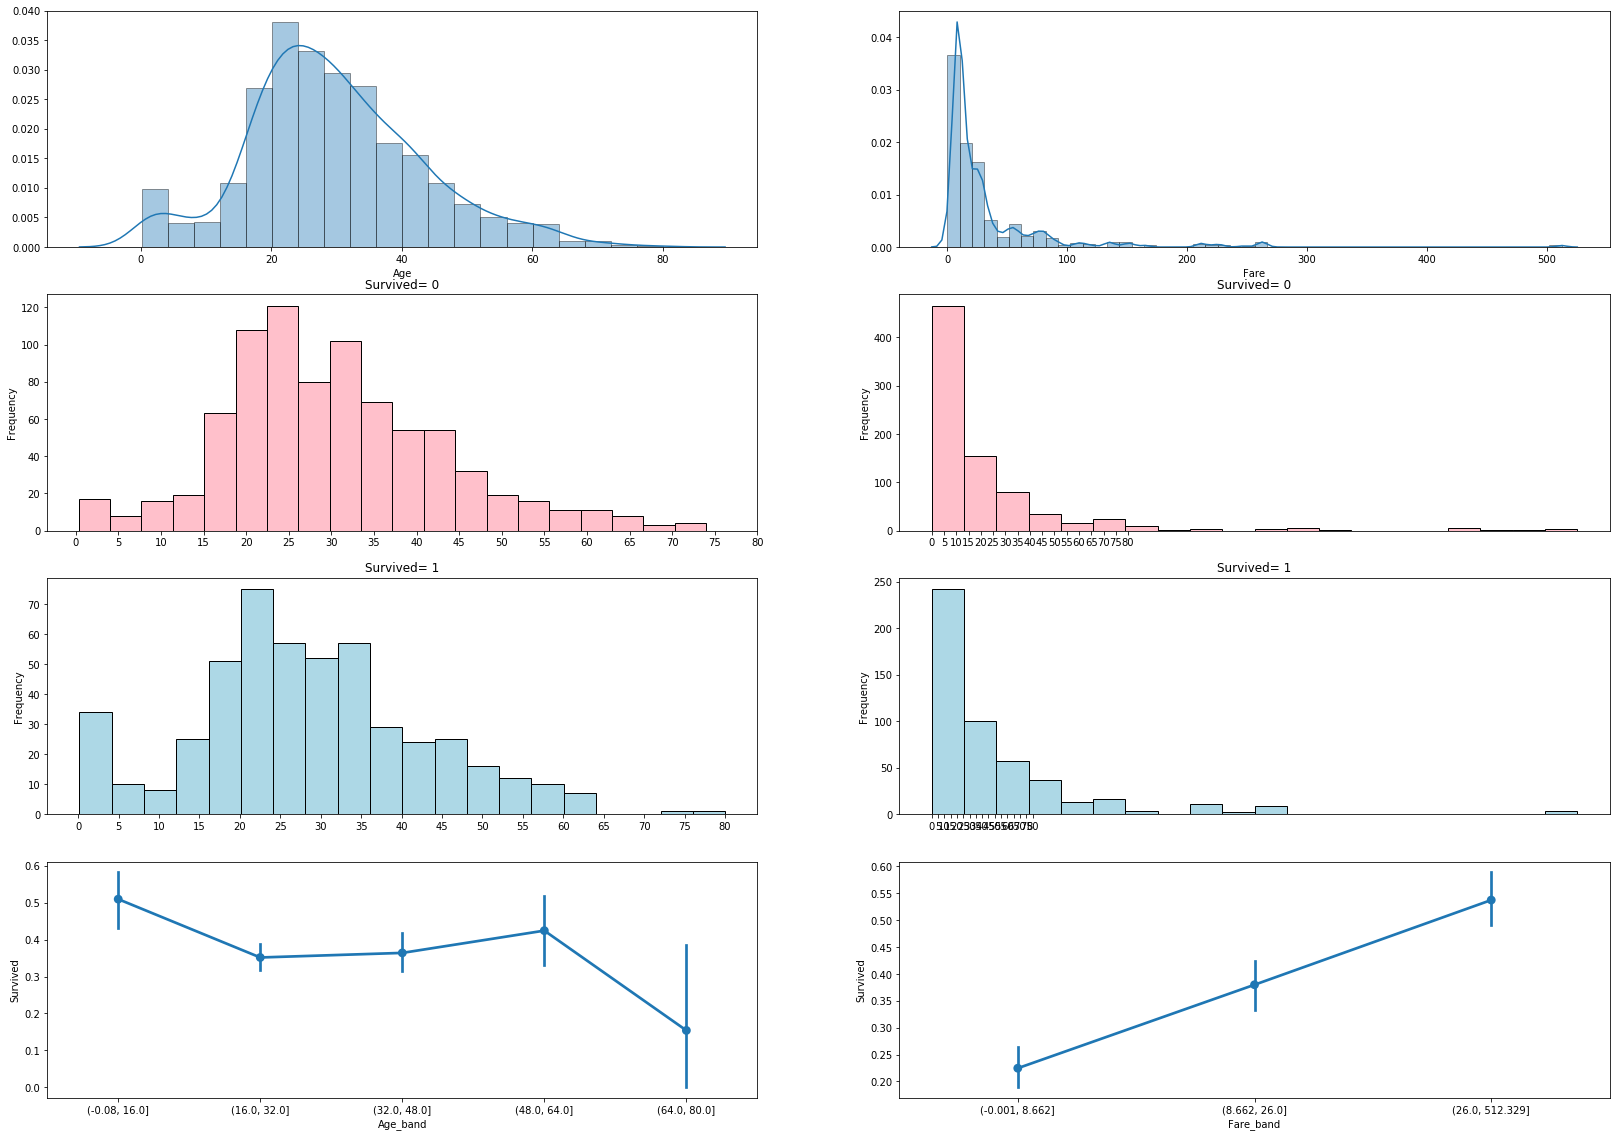

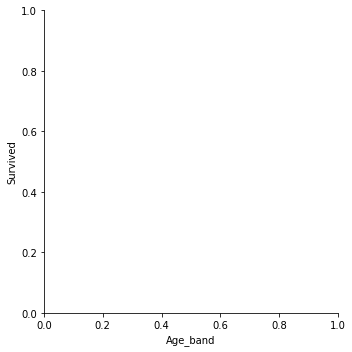

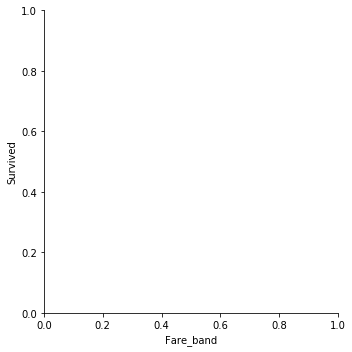

In [95]:
# Titanic5[['Age','Fare']].hist(figsize = (10,8),bins = 8)
f,ax = plt.subplots(4,2,figsize = (28,20))

sns.distplot(Titanic5['Age'],ax = ax[0,0],bins=20,hist_kws=dict(edgecolor="k"))
sns.distplot(Titanic5['Fare'],ax = ax[0,1],hist_kws=dict(edgecolor="k"))

Titanic6 = Titanic5.copy()

Titanic6[Titanic6['Survived']==0].Age.plot.hist(ax=ax[1,0],bins=20,edgecolor='black',color='pink')
ax[1,0].set_title('Survived= 0')
x1=list(range(0,85,5))
ax[1,0].set_xticks(x1)
Titanic6[Titanic6['Survived']==1].Age.plot.hist(ax=ax[2,0],bins = 20,edgecolor='black',color='lightblue')
ax[2,0].set_title('Survived= 1')
x2=list(range(0,85,5))
ax[2,0].set_xticks(x2)

Titanic6[Titanic6['Survived']==0].Fare.plot.hist(ax=ax[1,1],bins=20,edgecolor='black',color='pink')
ax[1,1].set_title('Survived= 0')
x1=list(range(0,85,5))
ax[1,1].set_xticks(x1)
Titanic6[Titanic6['Survived']==1].Fare.plot.hist(ax=ax[2,1],bins = 20,edgecolor='black',color='lightblue')
ax[2,1].set_title('Survived= 1')
x2=list(range(0,85,5))
ax[2,1].set_xticks(x2)

Titanic6['Age_band'] = pd.cut(Titanic6['Age'].astype(int), 5)
sns.factorplot('Age_band','Survived',data=Titanic6,size=5,ax = ax[3,0])

Titanic6['Fare_band'] = pd.qcut(Titanic6['Fare'], 3)
sns.factorplot('Fare_band','Survived',data=Titanic6,size=5,ax =ax[3,1])
Titanic7 = Titanic6.drop(['Age','Fare'],axis = 1)

plt.show()

Text(0.5,1,'Density Plot of Fare for Surviving Population and Deceased Population')

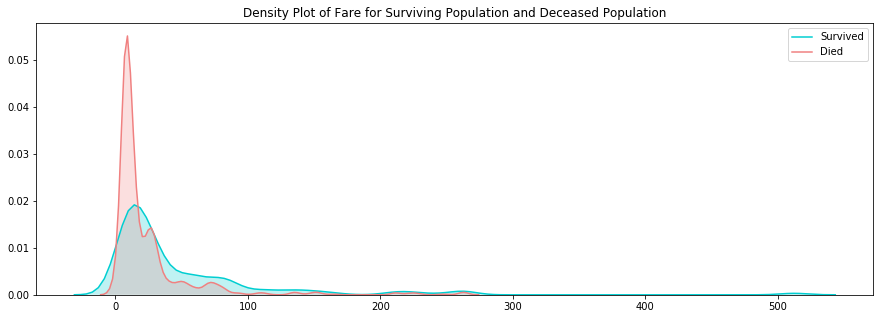

In [96]:
plt.figure(figsize=(15,5))
sns.kdeplot(Titanic6["Fare"][Titanic6.Survived == 1], color="darkturquoise", shade=True)
sns.kdeplot(Titanic6["Fare"][Titanic6.Survived == 0], color="lightcoral", shade=True)
plt.legend(['Survived', 'Died'])
plt.title('Density Plot of Fare for Surviving Population and Deceased Population')

As shown above, if we divide 'Age' into equal intervals, we will have some conclusions as follows:

1)The Toddlers(age<5) were saved in large numbers(The Women and Child First Policy).

2)The oldest Passenger was saved(80 years).

3)Maximum number of deaths were in the age group of 30-40. The survival probabilities between 16 to 48 are just 35%. The lowest survival probability is in range of [64-80]. Old people would like to give the lifeboat positions to someone younger.

For column 'Fare', not same as column 'Age', we discretize variable 'Fare' into 3 equal-sized buckets because there are 3 levels of 'pclass':

Passengers who paid lower fare appear to have been less likely to survive. Survival probability increases when fare increases. Rich people have almost half chance to survive.

##### * Barplots for Survival Probabilities Across All Features Which Are Not Continuous

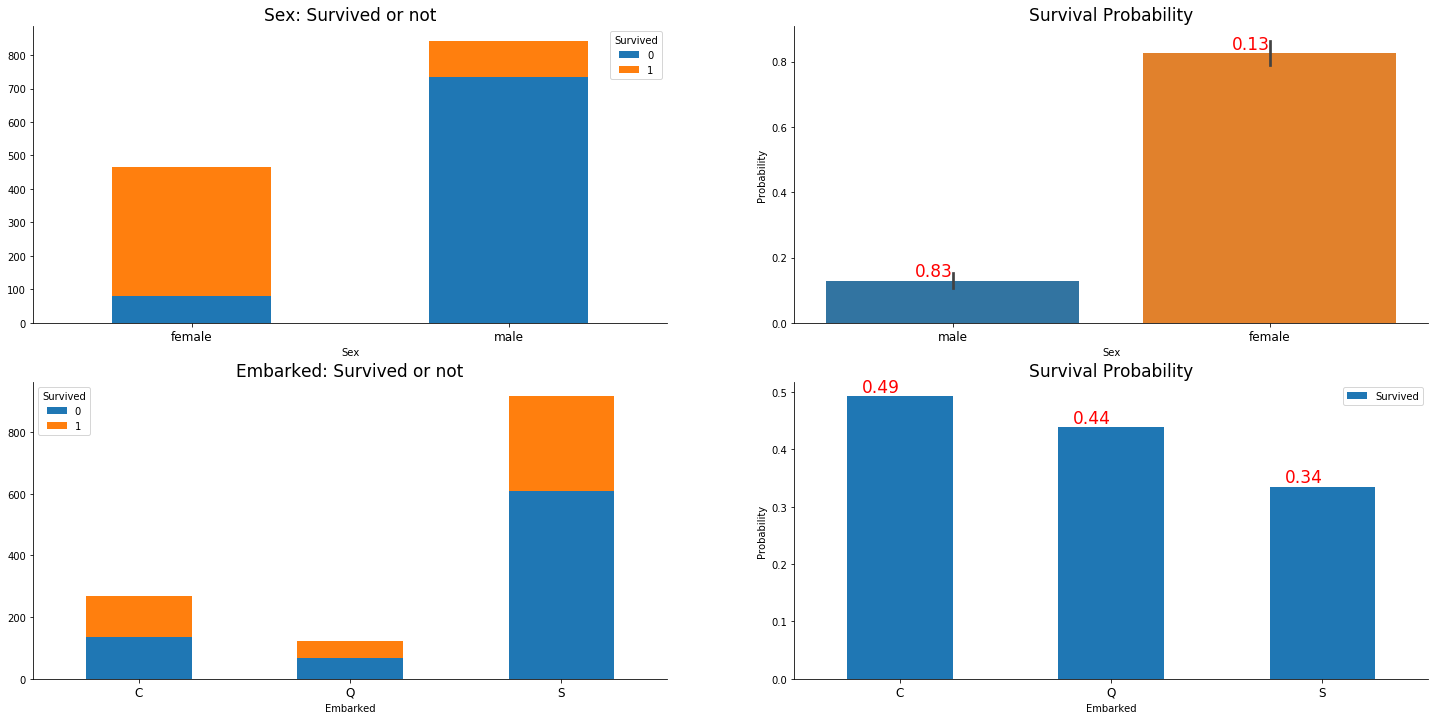

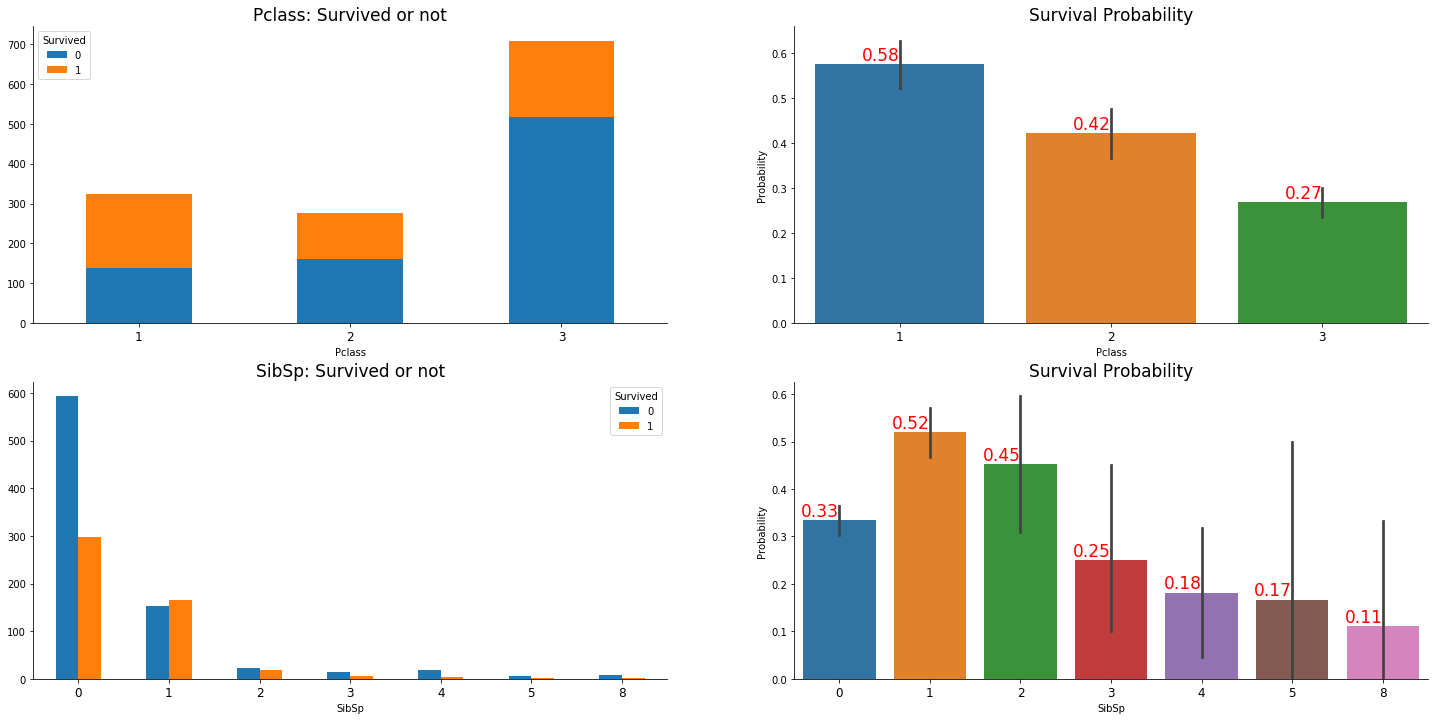

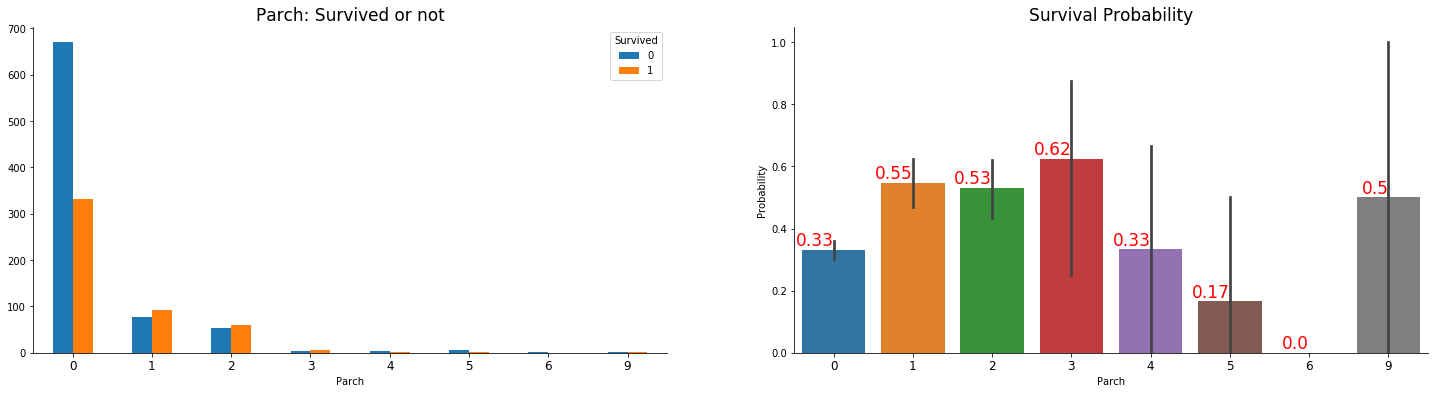

In [97]:
# Survival Probabilities across all features(Barplot)
f,ax = plt.subplots(2,2,figsize = (25,12))

pd.crosstab(Titanic7['Sex'],Titanic7['Survived']).plot.bar(stacked = True, ax = ax[0,0])
ax[0,0].set_title('Sex: Survived or not',fontsize=17)

# Titanic7[['Sex','Survived']].groupby('Sex').mean().plot.bar(ax = ax[0,1])
sns.barplot('Sex','Survived',data=Titanic7,ax=ax[0,1])
ax[0,1].set_title('Survival Probability',fontsize=17)
ax[0,1].set_ylabel('Probability')
ax[0,1].set_xlabel('Sex')
# ax[0,1].get_legend().remove()
rects = ax[0,1].patches
labels0 = Titanic7[['Sex','Survived']].groupby('Sex').mean()['Survived'].tolist()
labels1 = [ '%.2f' % elem for elem in labels0 ]
labels = [float(elem) for elem in labels1 ]
for rect, label in zip(rects, labels):
    height = rect.get_height()
    ax[0,1].text(rect.get_x() + rect.get_width() / 2, height, 
                 label,ha='right', va='bottom',fontsize=17,color = 'red')


pd.crosstab(Titanic['Embarked'],Titanic7['Survived']).plot.bar(stacked = True,ax = ax[1,0])
ax[1,0].set_title('Embarked: Survived or not',fontsize=17)

Titanic7[['Embarked','Survived']].groupby('Embarked').mean().plot.bar(ax = ax[1,1])
# sns.barplot('Embarked','Survived',data=Titanic7,ax=ax[1,1])
ax[1,1].set_title('Survival Probability',fontsize=17)
ax[1,1].set_ylabel('Probability')
ax[1,1].set_xlabel('Embarked')
# ax[1,1].get_legend().remove()
rects = ax[1,1].patches
labels0 = Titanic7[['Embarked','Survived']].groupby('Embarked').mean()['Survived'].tolist()
labels1 = [ '%.2f' % elem for elem in labels0 ]
labels = [float(elem) for elem in labels1 ]
for rect, label in zip(rects, labels):
    height = rect.get_height()
    ax[1,1].text(rect.get_x() + rect.get_width() / 2, height, 
                 label,ha='right', va='bottom',fontsize=17,color = 'red')

for ax in f.axes:
    plt.sca(ax)
    plt.xticks(rotation=0,fontsize = 12)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False) 

##############################################################################
f,ax = plt.subplots(2,2,figsize = (25,12))

pd.crosstab(Titanic7['Pclass'],Titanic7['Survived']).plot.bar(stacked = True,ax = ax[0,0])
ax[0,0].set_title('Pclass: Survived or not',fontsize=17)

# Titanic7[['Pclass','Survived']].groupby('Pclass').mean().plot.bar(ax = ax[0,1])
sns.barplot('Pclass','Survived',data=Titanic7,ax=ax[0,1])
ax[0,1].set_title('Survival Probability',fontsize=17)
ax[0,1].set_ylabel('Probability')
ax[0,1].set_xlabel('Pclass')
# ax[0,1].get_legend().remove()
rects = ax[0,1].patches
labels0 = Titanic7[['Pclass','Survived']].groupby('Pclass').mean()['Survived'].tolist()
labels1 = [ '%.2f' % elem for elem in labels0 ]
labels = [float(elem) for elem in labels1 ]
for rect, label in zip(rects, labels):
    height = rect.get_height()
    ax[0,1].text(rect.get_x() + rect.get_width() / 2, height, 
                 label,ha='right', va='bottom',fontsize=17,color = 'red')
    
pd.crosstab(Titanic['SibSp'],Titanic7['Survived']).plot.bar(ax = ax[1,0])
ax[1,0].set_title('SibSp: Survived or not',fontsize=17)

# Titanic7[['SibSp','Survived']].groupby('SibSp').mean().plot.bar(ax = ax[1,1])
sns.barplot('SibSp','Survived',data=Titanic7,ax=ax[1,1])
ax[1,1].set_title('Survival Probability',fontsize=17)
ax[1,1].set_ylabel('Probability')
ax[1,1].set_xlabel('SibSp')
# ax[1,1].get_legend().remove()
rects = ax[1,1].patches
labels0 = Titanic7[['SibSp','Survived']].groupby('SibSp').mean()['Survived'].tolist()
labels1 = [ '%.2f' % elem for elem in labels0 ]
labels = [float(elem) for elem in labels1 ]
for rect, label in zip(rects, labels):
    height = rect.get_height()
    ax[1,1].text(rect.get_x() + rect.get_width() / 2, height, 
                 label,ha='right', va='bottom',fontsize=17,color = 'red')

for ax in f.axes:
    plt.sca(ax)
    plt.xticks(rotation=0,fontsize = 12)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False) 

#################################################################################
f,ax = plt.subplots(1,2,figsize = (25,6))

pd.crosstab(Titanic7['Parch'],Titanic7['Survived']).plot.bar(ax = ax[0])
ax[0].set_title('Parch: Survived or not',fontsize=17)

# Titanic7[['Parch','Survived']].groupby('Parch').mean().plot.bar(ax = ax[1])
sns.barplot('Parch','Survived',data=Titanic7,ax=ax[1])
ax[1].set_title('Survival Probability',fontsize=17)
ax[1].set_ylabel('Probability')
ax[1].set_xlabel('Parch')
# ax[1].get_legend().remove()
rects = ax[1].patches
labels0 = Titanic7[['Parch','Survived']].groupby('Parch').mean()['Survived'].tolist()
labels1 = [ '%.2f' % elem for elem in labels0 ]
labels = [float(elem) for elem in labels1 ]
for rect, label in zip(rects, labels):
    height = rect.get_height()
    ax[1].text(rect.get_x() + rect.get_width() / 2, height, 
                 label,ha='right', va='bottom',fontsize=17,color = 'red')

for ax in f.axes:
    plt.sca(ax)
    plt.xticks(rotation=0,fontsize = 12)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)


From barplots above we have some conclusions:

(1) 'Gender' really matters!

Number of men is almost twice as the number of women, however, the number of men saved is just one third of women saved. The percentage of survived women is 83% among all women on board, but the percentage of survived men is pretty low, just 13% male were saved. The result shows that gentlemen in Titanic complied with the 'Ladies first' rule at the most critical juncture, most of them sacrificed themselves and gave the living opportunities to women.

(2) Maximum passenegers boarded from Southampton, however, these people have the lowest survival probability.

(3) Almost half passengers are from class 3, but survival probability of class 3 is just 27%. Class 1 have much higher priority while rescue, their survival probability is almost 60%.

(4) Most passengers have no sibling or husband/wife on board. Passengers without sibsp have 33% chance to be rescured. So a lot of people alone died. The highest survival probability is from people who have 1 sibsp on board. Then as the number increases, the probability decreases quickly. It totally makes sense. If people have sibsp, they will try to save others members in their family, it will be hard and need more time to achieve. However, for people who just have 1 sibsp, they have enough time to run and they will help each other as well when emergency happens. This is the reason why people with 1 sibsp have highest survival probability. 

(5) The trend of 'Parch' is quite similar as 'SibSp'. Most passengers have nerither parents nor children. Just 33% of them were rescued. Passengers with parents have more chances to survive, but if they have more than 4 family members, their survival probability will decrease.

###### We can combine 'SibSp' and 'Parch' together, create a new column called 'NumFamily':

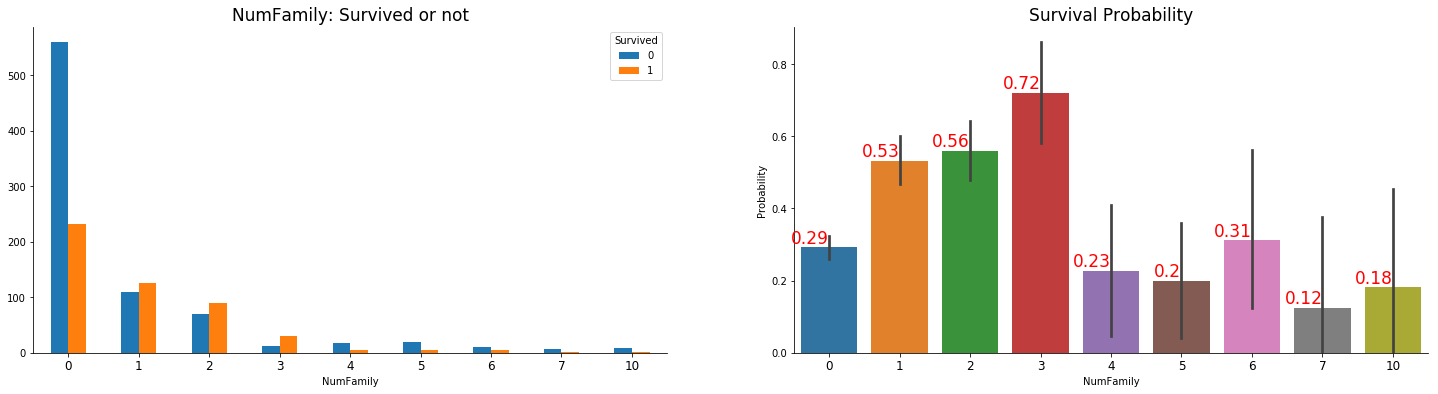

In [98]:
Titanic8 = Titanic5.copy()
Titanic8['NumFamily'] = Titanic8['SibSp']+Titanic8['Parch']
Titanic8 = Titanic8.drop(['Parch','SibSp'],axis = 1)

f,ax = plt.subplots(1,2,figsize = (25,6))

pd.crosstab(Titanic8['NumFamily'],Titanic8['Survived']).plot.bar(ax = ax[0])
ax[0].set_title('NumFamily: Survived or not',fontsize=17)

# Titanic8[['NumFamily','Survived']].groupby('NumFamily').mean().plot.bar(ax = ax[1])
sns.barplot('NumFamily','Survived',data=Titanic8,ax=ax[1])
ax[1].set_title('Survival Probability',fontsize=17)
ax[1].set_ylabel('Probability')
ax[1].set_xlabel('NumFamily')
# ax[1].get_legend().remove()
rects = ax[1].patches
labels0 = Titanic8[['NumFamily','Survived']].groupby('NumFamily').mean()['Survived'].tolist()
labels1 = [ '%.2f' % elem for elem in labels0 ]
labels = [float(elem) for elem in labels1 ]
for rect, label in zip(rects, labels):
    height = rect.get_height()
    ax[1].text(rect.get_x() + rect.get_width() / 2, height, 
                 label,ha='right', va='bottom',fontsize=17,color = 'red')

for ax in f.axes:
    plt.sca(ax)
    plt.xticks(rotation=0,fontsize = 12)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

From barplots of 'NumFamily' we find:

The trend of survival probability increases at the begining but decreases after 3. passengers with 3 family members have 72% probability to be saved, it is high. Most of passengers are alone on board. death rate of these kind of people is high. Just 29% of them were rescued. Why people with large family have lower survival probability? Let's take a look at the plots as follows:

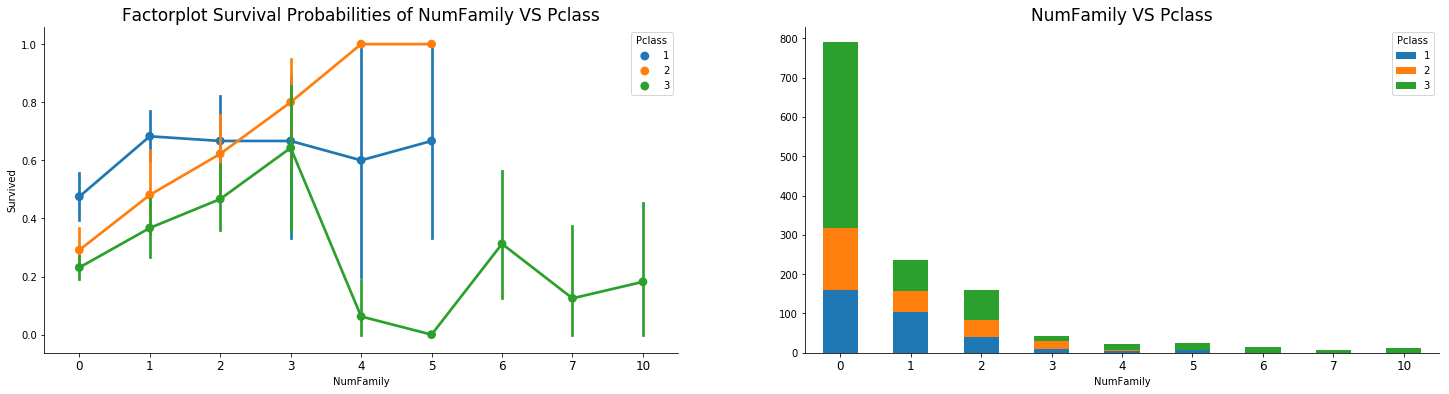

NumFamily,0,1,2,3,4,5,6,7,10
Pclass,,,,,,,,,
1,160,104,39,9,5,6,0,0,0
2,158,52,45,20,1,1,0,0,0
3,472,79,75,14,16,18,16,8,11


In [99]:
f,ax = plt.subplots(1,2,figsize = (25,6))
sns.pointplot(x="NumFamily", y="Survived", hue="Pclass", data=Titanic8,ax = ax[0])
ax[0].set_title('Factorplot Survival Probabilities of NumFamily VS Pclass',fontsize = 17)
pd.crosstab(Titanic8['NumFamily'],Titanic8['Pclass']).plot.bar(stacked = True, ax = ax[1])
ax[1].set_title('NumFamily VS Pclass',fontsize=17)

for ax in f.axes:
    plt.sca(ax)
    plt.xticks(rotation=0,fontsize = 12)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
plt.show()

pd.crosstab(Titanic8['Pclass'],Titanic8['NumFamily']).style.background_gradient(cmap='summer_r')

From plots shown above, we know the passengers with big family are from class 3. Money is important! Most of passengers are from class 3, plenty of people in class 3 died, especially passengers with large family and single passengers from class 3.

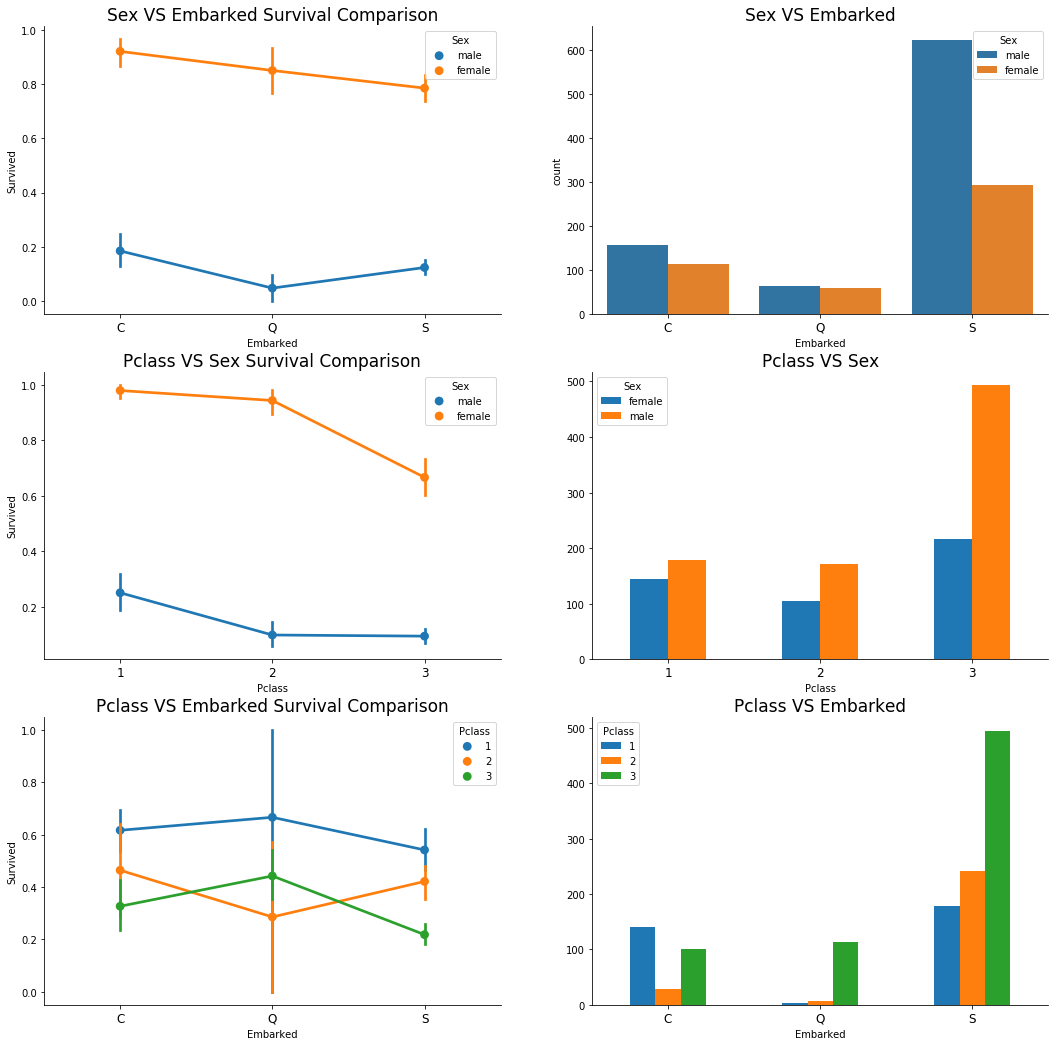

In [100]:
# Categorical Features: Sex

f,ax=plt.subplots(3,2,figsize=(18,18))
sns.pointplot(x = 'Embarked', y = 'Survived', hue = 'Sex', order = ['C','Q','S'],data=Titanic8, ax = ax[0,0])
ax[0,0].set_title('Sex VS Embarked Survival Comparison',fontsize = 17)

# pd.crosstab(Titanic8['Embarked'],Titanic8['Sex']).plot.bar(ax = ax[1,0])
sns.countplot(x = 'Embarked', hue = 'Sex',order = ['C','Q','S'], data =Titanic8,ax = ax[0,1])
ax[0,1].set_title('Sex VS Embarked',fontsize = 17)

sns.pointplot(x = 'Pclass', y = 'Survived', hue = 'Sex',data=Titanic8, ax  = ax[1,0])
ax[1,0].set_title('Pclass VS Sex Survival Comparison',fontsize = 17)

pd.crosstab(Titanic8['Pclass'],Titanic8['Sex']).plot.bar(ax = ax[1,1])
ax[1,1].set_title('Pclass VS Sex',fontsize = 17)

sns.pointplot(x = 'Embarked', y = 'Survived', hue = 'Pclass', order = ['C','Q','S'],data=Titanic8, ax  = ax[2,0])
ax[2,0].set_title('Pclass VS Embarked Survival Comparison',fontsize = 17)

pd.crosstab(Titanic8['Embarked'],Titanic8['Pclass']).plot.bar(ax = ax[2,1])
ax[2,1].set_title('Pclass VS Embarked',fontsize = 17)

for ax in f.axes:
    plt.sca(ax)
    plt.xticks(rotation=0,fontsize = 12)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

plt.show()

Condlusions from the plots above:

(1)'Lady first' principle is corret no matter which port are you from(Embarked) and whether you are rich or not(Pclass). Survival probability of female is much higher than male. Survival probability of men from Queenstown is the lowest, less than 10% of them were saved. But men from Southampton have the largest number of death, 546, almost half people in Titanic. That's horrible:(

(2)Maximum passenegers boarded from Southampton Majority of them being from Pclass3.

(3)The Embark Southampton looks to the port from where majority of the rich people boarded. Still the chances for survival is low here, that is because many passengers from Pclass3 around 81% didn't survive.

(4)Port Queenstown had almost 95% of the passengers were from Pclass3.

##### * Redundancy and Correlation Analysis 
Redundancy is an important issue in data integration. An attribute may be redundant if it can be “derived” from another attribute or set of attributes. In Titanic dataset, there are categorical variables and numerical variables, we need to treat different types using different methods.

(1) For numerical variables, we use correlation heatmap as follows:

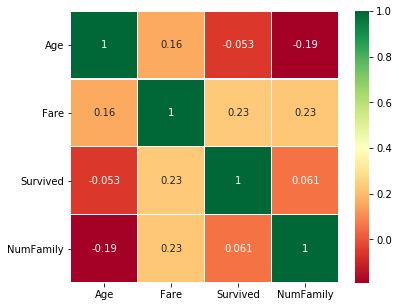

In [101]:
Titanic8['Pclass'] = Titanic8['Pclass'].astype('category',ordered=False)

sns.heatmap(Titanic8.corr(),annot=True,cmap='RdYlGn',linewidths=0.2) #data.corr()-->correlation matrix
fig=plt.gcf()
fig.set_size_inches(6,5)
plt.show()

From correlation heatmap shown above, we find all features are not much correlated to each other. It is a good notice. It means there is not too much multicolinearity between numarical variables in our dataset.

(2) For categorical variables, we will use **Chi-squared Correlation Test**(Pearson Chi-squared Statistic) to check the correlation relationships.

Pearson Chi-squared Test is a statistical hypothesis test that assumes the observed frequencies for a categorical variable match the expected frequencies for the categorical variable. The null hypothesis is that there is no relationship between categorical variables. The Chi-Squared test does this for a contingency table, first calculating the expected frequencies for the groups, then determining whether the division of the groups, called the observed frequencies, matches the expected frequencies. The test calculates a statistic that has a chi-squared distribution. If p value is small enough, we determine that null hypothese should be denied. 

We can give an example using 'Survived' VS 'Sex' in Titanic data:
<img src = "chi-squared.png" width = 450 >
From this screenshot, we can see there is association between 'Survived and 'Sex' because the null hypothese is 'Survived' is independent of 'Sex'.
If you want to know the detail about chi-squared test in Excel, please see this link: http://www.real-statistics.com/chi-square-and-f-distributions/independence-testing/ And https://datascience.stackexchange.com/questions/893/how-to-get-correlation-between-two-categorical-variable-and-a-categorical-variab

Well, let's do Chi-squared Correlation Test for categorical variables using python as follows:

In [102]:
CategList = ['Survived','Title','Sex','Embarked','Pclass']
from itertools import combinations
A = list(combinations(CategList, 2))

for pairs in A:
    observed = pd.crosstab(Titanic8[pairs[0]],Titanic8[pairs[1]])
    Chi2,Pvalue,DF,ExpectedTable=stats.chi2_contingency(observed= observed)
    if Pvalue >= 0.05:
        print(' %s and %s are independent: Accept H0'%(pairs[0],pairs[1]))
    else:
        print(' %s is associated with %s : Reject H0'%(pairs[0],pairs[1]))

 Survived is associated with Title : Reject H0
 Survived is associated with Sex : Reject H0
 Survived is associated with Embarked : Reject H0
 Survived is associated with Pclass : Reject H0
 Title is associated with Sex : Reject H0
 Title is associated with Embarked : Reject H0
 Title is associated with Pclass : Reject H0
 Sex is associated with Embarked : Reject H0
 Sex is associated with Pclass : Reject H0
 Embarked is associated with Pclass : Reject H0


From Chi-squared Test results, we find associations between every two categorical variables. Which features matter more? How to fix the redundancy? This might be a new problem. We can sort feature importance in the future.

## Conclusion
In module 1, we did exploratory analysis on Titanic dataset, found some interesting results. Gender and Class are important. Even though rich people have higher survival possibility, when a devastating disaster occured, people in Titanic showed the fearless and kindness nature of human-being. Middle-aged Male gave up the position of lifeboat to woman and children. Old people prefer to save younger people instead of saving themselves. In the face of natural disasters, human beings are quite small and powerless, however, love shows its power. The victims deserve our reverence and remembrance forever.

In next module, we will apply several machine learning methods and do the comparison based on the data evaluation results. Please read 'Predict Survival on Titanic Datasets Using Classification Methods(Part 2)' if you like.

In [103]:
# Titanic9 = Titanic8.copy()
# Titanic9.loc[Titanic9.Title=='Mr','Title'] = '0'
# Titanic9.loc[Titanic9.Title=='Mrs','Title']= '1'
# Titanic9.loc[Titanic9.Title=='Master','Title']= '2'
# Titanic9.loc[Titanic9.Title=='Miss','Title']= '3'
# Titanic9.loc[Titanic9.Title=='Others','Title']= '4'
# Titanic9.loc[Titanic9.Sex=='male','Sex']= '0'
# Titanic9.loc[Titanic9.Sex=='female','Sex']= '1'
# Titanic9.loc[Titanic9.Embarked=='C','Embarked']= '0'
# Titanic9.loc[Titanic9.Embarked=='Q','Embarked']= '1'
# Titanic9.loc[Titanic9.Embarked=='S','Embarked']= '2'
# Titanic9['Title'] = [int(x) for x in Titanic9['Title']]
# Titanic9['Sex'] = [int(x) for x in Titanic9['Sex']]
# Titanic9['Embarked'] = [int(x) for x in Titanic9['Embarked']]

Titanic8.to_csv('Titanic_Data_Preparation.csv')

In [104]:
Test_Id.to_csv('TestDataIndex.csv')